<a href="https://colab.research.google.com/github/storimaging/Notebooks/blob/main/Restoration/Sampling_TV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Total Variation sampling with the Metropolis algorithm

**Authors:**
* [Julie Delon](https://github.com/judelo) 
* Lucía Bouza

## Reminders on the sampling of $e^{-H}$

In the following, we wish to draw samples from the distribution 
$$ \pi_{H}(x) \propto e^{-H(x)},$$
assuming that $\int_x e^{-H(x)} dx < +\infty$.
For instance, if we want to know what images with a TV prior look like, we can choose $H(x) = \beta \mathrm{TV}(x) + \epsilon \|x\|^2$ for a very small value of $\epsilon$ (the term $\epsilon \|x\|^2$ ensures  $\int_x e^{-H(x)} dx< +\infty$). 


In order to draw samples from $ \pi_{H}$, we will use a Metropolis algorithm, inspired by what is used in 

[Louchet, C., & Moisan, L. (2008, August). Total variation denoising using posterior expectation, EUSIPCO 2008](https://hal.archives-ouvertes.fr/hal-00258849/file/lm08ok.pdf). 

 We will sample $n_r\times n_c$ images and we call $\Gamma$ the discrete grid $\{1,\dots,n_r\}\times  \{1,\dots,n_c\}$. 

## Metropolis algorithm for sampling $X\sim \pi_{H}$
1. *Initialization : sample a $n_r\times n_c$ random image $x_0$ (realization of a i.i.d. white noise for instance)*
2. *for k from 1 to N (with N large)*
    + *sample randomly and indepentely: a pixel $(i,j)$ with a uniform law on the grid  $\Gamma$, a variable $z\sim \mathcal{U}([0,1])$, and a variable $t \sim \mathcal{U}([-\alpha,\alpha])$* ($\alpha$ is a parameter of the algorithm)
    + *call $x_{temp}$ the image obtained by replacing $x_k(i,j)$ by $x_k(i,j) + t$ (not touching other pixels)*
    + *if $z < e^{-(H(x_{temp}) - H(x_k) ) }$, define $x_{k+1} = x_{temp}$ and define $x_{k+1}=x_k$ otherwise.*
3. *Return $x_N$.* 

## Importing packages

Below is a list of packages required in the notebook.

* `Numpy`
* `matplotlib.pyplot` (display of images and graphics)
* `os` (interactions with the operating system)
* `time` (measure time)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

To import the solutions, execute the following cell. If you are using a Windows system, comment the `os.system` line, download the file by hand, and place it in the same folder as the notebook.

In [2]:
#os.system("wget -nc https://raw.githubusercontent.com/storimaging/Notebooks/main/Restoration/Solutions/TV.py")
#from TV import *

## Helper functions

In the next cell we define some functions for displaying images and compute the total variation of an image. 

In [3]:
#@title

# Function to display two images
def printImages(a, b, title_a, title_b, size1, size2):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(size1, size1))
    axes[0].set_title(title_a)
    axes[0].imshow(a,cmap='gray',vmin=0,vmax=1)
    axes[0].axis('off')
    axes[1].set_title(title_b)
    axes[1].imshow(b,cmap='gray',vmin=0,vmax=1)
    axes[1].axis('off')
    fig.tight_layout()
    plt.show()

# Function to display four images
def print4Images(a, b, c, d, title_a, title_b, title_c, title_d, size1, size2):

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(size1, size1))
    axes[0].set_title(title_a)
    axes[0].imshow(a,cmap='gray',vmin=0,vmax=1)
    axes[0].axis('off')
    axes[1].set_title(title_b)
    axes[1].imshow(b,cmap='gray',vmin=0,vmax=1)
    axes[1].axis('off')
    axes[2].set_title(title_c)
    axes[2].imshow(c,cmap='gray',vmin=0,vmax=1)
    axes[2].axis('off')
    axes[3].set_title(title_d)
    axes[3].imshow(d,cmap='gray')
    axes[3].axis('off')
    fig.tight_layout()
    plt.show()

# Define total variation of an image
def TV1(u):
    return  np.sum(np.sum(np.abs(np.roll(u,1,axis=0)- u)+np.abs(np.roll(u,1,axis=1) - u)))

## Sampling $e^{- \beta \mathrm{TV}-\epsilon \|.\|_2^2}$

We wish to implement the previous algorithm to draw samples from the distribution $e^{-\beta \mathrm{TV}-\epsilon \|.\|^2}$, where we recall that (for simplicity we use the norm 1 version of TV here):
$$TV(u) = \sum_{i,j} |u(i+1,j) - u(i,j)|+ |u(i,j+1) - u(i,j)|.$$

To implement the Metropolis algorithm, we could loop on the pixels of $u$, but the algorithm would be terribly slow. A solution is to parallelize the function on independent pixels to speed up the computations: pixels at distance larger than 2 can be modified simultaneously, but we should be careful to compute $z < e^{-(H(x_{temp}) - H(x_k) ) }$ independently for each of these modified pixels in order to decide if we keep the local modification at the pixel or not. 

- To do so, we can start by writing a function `deltaTV_pointwise ` which computes the map of differences really involved in the computation of $H(x_{temp})-H(x_k)$ when the pixel $(i,j)$ is modified.  
Indeed, observe that changing the value at pixel $(i,j)$ only affects the total variation at $(i,j)$, $(i-1,j)$ and $(i,j-1)$. 
In the total sum $TV(u)$, the values affected by these modifications are thus all values involving $u(i,j)$, i.e.
$$|u(i+1,j) - u(i,j)|+ |u(i,j+1) - u(i,j)|+ |u(i,j) - u(i-1,j)|+ |u(i,j) - u(i,j-1)|.$$
For simplicity we can assume that your image is periodic and make use of the function ``np.rol``.


> ![Text](https://raw.githubusercontent.com/storimaging/Images/main/SupportImages/TotalVariation.jpg) 


Using the function `deltaTV_pointwise`, we can implement the Metropolis algorithm to sample $e^{-H}$. Write a `function metropolis_TV1` with the following parameters: random image $x_0$, $\alpha$, number of iterations, and a dictionary of options including $\beta$ and $\epsilon$. 


- Start with a small value of $\beta$ (1 for instance) and draw several samples of the distributions, then increase the value of $\beta$. What do you observe?  
- Observe also the variation of $TV(u)$ along iterations (and the range of values of these realizations), for different values of $\beta$.

In [4]:
# initializations for display results
out = []
tv_out = []
t0 = time.time()

# Parameters
noise = np.random.rand(50,50)
N = int(1e4) # number of iterations 
alpha = 0.1  # parameter of the algorithm
epsilon = 1e-12 # for the quadratic term
betas = [1, 10, 100] 

for beta in betas:
    opts =  dict(beta=beta, epsilon=epsilon)
    x = np.copy(noise)  # initialization    
    temp = metropolis_TV1(x,alpha,N, **opts)
    out = out + [temp]
    tv_out = tv_out + [TV1(temp)]
    
t1 = time.time() 
print("time spent (on 3 runs): ", t1-t0)

time spent (on 3 runs):  28.714768648147583


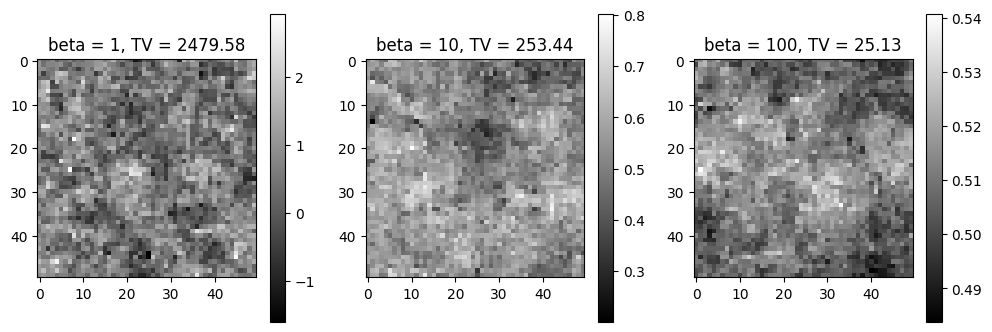

In [5]:
# Print results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i in range(len(betas)):
    dr = axes[i].imshow(out[i],cmap='gray')
    fig.colorbar(dr,ax = axes[i])
    axes[i].set_title('beta = {}, TV = {:.2f}'.format( betas[i], tv_out[i]))

## Sampling $e^{-\left(\lambda \mathrm{TV(u)+\|u-u_0\|^2/{2\sigma^2}}\right)}$

Now, we wish to sample from the distribution 
$$\pi(u) \propto e^{-\left(\lambda \mathrm{TV(u)+\|u-u_0\|^2/{2\sigma^2}}\right)}$$

We can use exactly the same approach as before.
- Implement the previous algorithm to draw samples from the distribution $\pi$. Again write everything locally and parallelize on independent pixels for efficiency.
- Implement your algorithm so you can compute the average value of all samples after a burn-in phase. If $x_t$ is the sample at iteration $t$, you can do it iteratively by initializing the mean to 0 and updating at iteration t:
$$x_{mean} = t/(t+1)*x_{mean} + 1/(t+1)*x_{t}$$
- using the same trick, compute the standard deviation of your samples
- as a sanity check, you can observe the number of pixels where the perturbation is accepted at each iteration. This number should be a non trivial proportion of the modified pixels.
- try different initializations for the Markov chain. Does your average posterior depend on your initialization ? 
- compare the average posterior $x_{mean}$ with the MAP obtained with the Chambolle-Pock algorithm (see the notebook on **variational approaches for image restoration**). In particular, observe that the staircasing effect present in the TV MAP doesn't appear in the average posterior, as shown in 
[Louchet, C., & Moisan, L. (2008, August). Total variation denoising using posterior expectation, EUSIPCO 2008](https://hal.archives-ouvertes.fr/hal-00258849/file/lm08ok.pdf). 

The following cell imports the code for the Chambolle-Pock algorithm (see the notebook on **variational approaches for image restoration**) to compute MAP restoration for TVL2 / TVL1 formulations.


In [6]:
os.system("wget -nc https://raw.githubusercontent.com/storimaging/Notebooks/main/Restoration/Solutions/chambolle_pock_prox_TV.py")
from chambolle_pock_prox_TV import *

The code to sample $\frac 1 Z e^{-\left(\lambda \mathrm{TV(u)+\|u-u_0\|^2/{2\sigma^2}}\right)}$ is almost the same as the one written before, with the additional data term, and the slight modification to compute the empirical mean of the Markov chain. Write the function `metropolis_TVL2` with the same parameters as `metropolis_TV1`.


In the next cell we will create a noisy image. We will crop the original image to accelerate the process. 

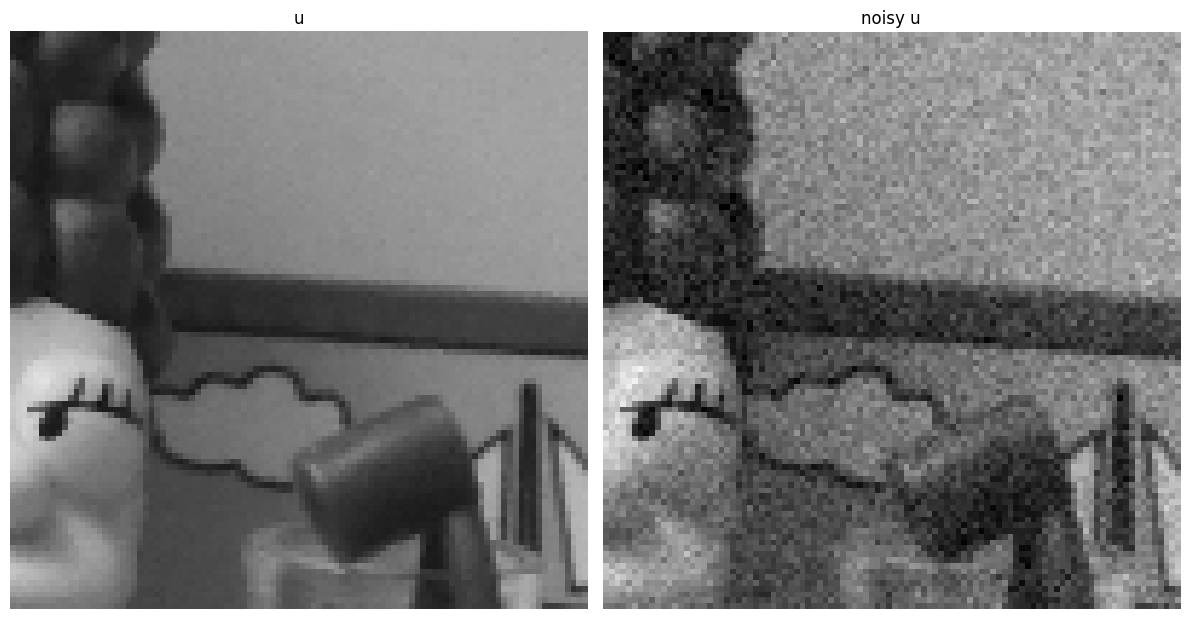

In [7]:
# Read image
os.system("wget -c https://raw.githubusercontent.com/storimaging/Images/main/img/simpson_nb512.png")
u = plt.imread("simpson_nb512.png")

# Crop image: start with small images for your experimentations
n = 100    
i = 100
u = u[i:i+n,i:i+n]

# Add noise
nr,nc = u.shape
sigma = 0.05
ub = u + sigma*np.random.randn(nr,nc)

# Print images
printImages(u, ub, "u", "noisy u", 12, 7)

Next we run the Metropolis algorithm (be patient, it can take a few dozens of seconds depending on your configuration, use a small number of iterations at first to test the algorithm). We also run the Chambolle-Pock TV-L2 algorithm for comparison purposes.

time spent:  54.20481872558594


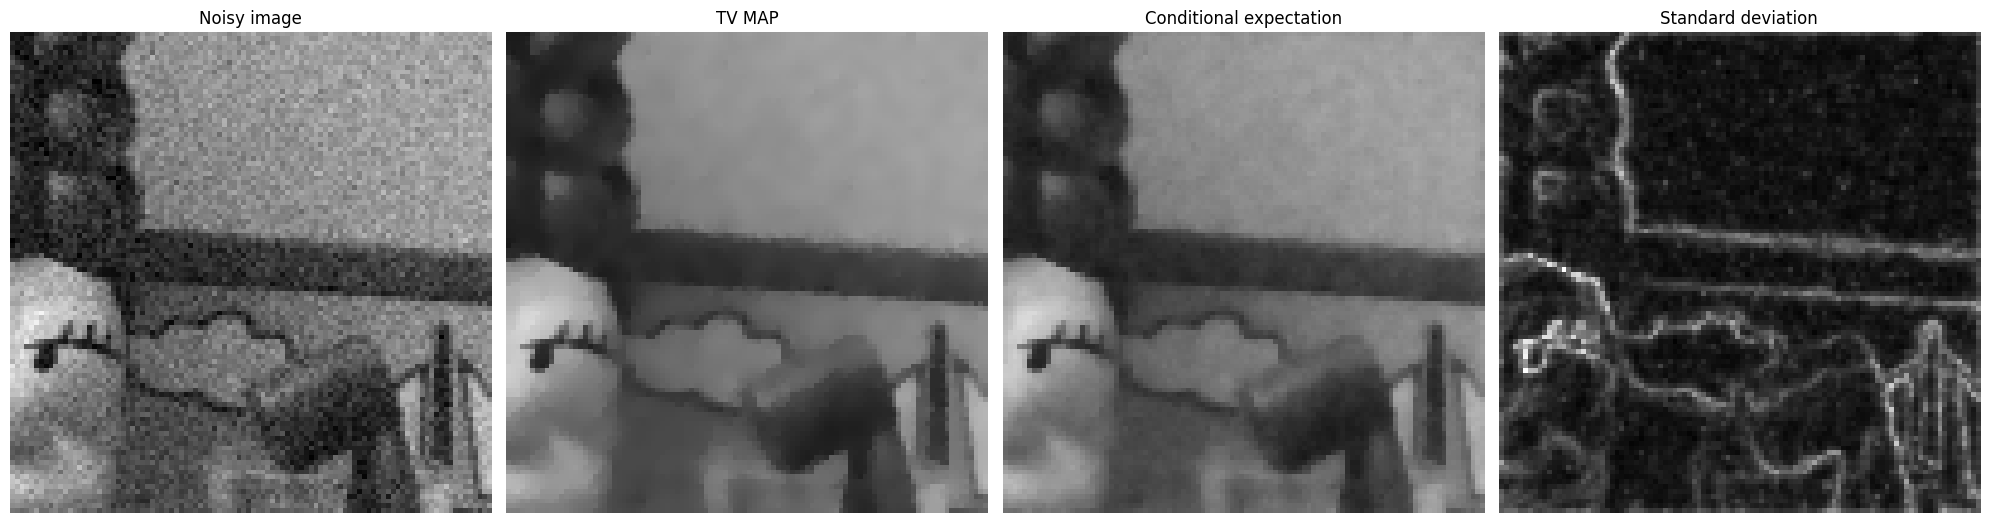

In [8]:
# Parameters for the MCMC
N = int(5e4)   # Choose N<1e4 for your experiments
alpha = 0.1  
lambd = 20     # TV regularization parameter 
opts =  dict(ub=ub, sigma=sigma, lambd=lambd)

# Metropolis algorithm
t0   = time.time()
x = np.random.rand(nr,nc) # Initialization
x,xmean,stdx = metropolis_TVL2(x,alpha,N,**opts)
t1 = time.time()
print("time spent: ", t1-t0)

# TV-MAP
u_tvmap = chambolle_pock_prox_TV("TVL2",ub,sigma**2*lambd,100)

# Print results
print4Images(ub, u_tvmap, xmean, stdx, 'Noisy image', 'TV MAP', 'Conditional expectation', 'Standard deviation', 20, 5)

## Sampling $e^{-\left(\lambda \mathrm{TV(u)+\|Au-u_0\|^2/{2\sigma^2}}\right)}$ with diagonal A

In the following, we apply the same approach as above for an interpolation problem. We wish to sample from the distribution 
$$\pi(u) \propto e^{-\left(\lambda \mathrm{TV(u)+\|Au-u_0\|^2/{2\sigma^2}}\right)}$$
where $A$ is a masking operator (diagonal matrix with $0$ and $1$ on the diagonal). 
Since $A$ acts independently on each pixel, we can use exactly the same approach as before, working in parallel on independent pixels (at distance >=2). Working with a non diagonal $A$ would be much more complex.

In the next cell we create an image with missing pixels and additive noise. We use a crop of the original image to accelerate the process. 

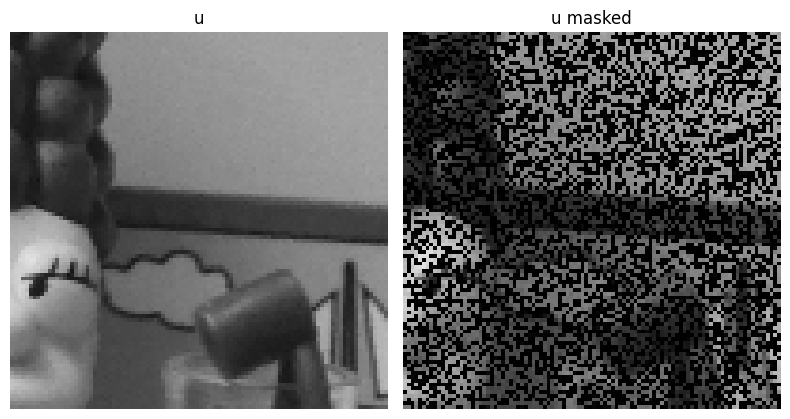

In [9]:
# Add mask and noise
mask  = np.random.rand(nr,nc)<0.5
sigma = 0.02
ub = u*mask + sigma*np.random.randn(nr,nc)

# Print images 
printImages(u, ub, "u", "u masked", 8, 8) 

The code to sample $\frac 1 Z e^{-\left(\lambda \mathrm{TV(u)+\|Au-u_0\|^2/{2\sigma^2}}\right)}$ with diagonal $A$ is again very similar to the previous one. Write the function `metropolis_TVL2A` to implement it. 

In the next cell we run the Metropolis algorithm. We  also run the Chambolle-Pock TV-L2 algorithm for comparison purposes.

time spent:  33.64576315879822


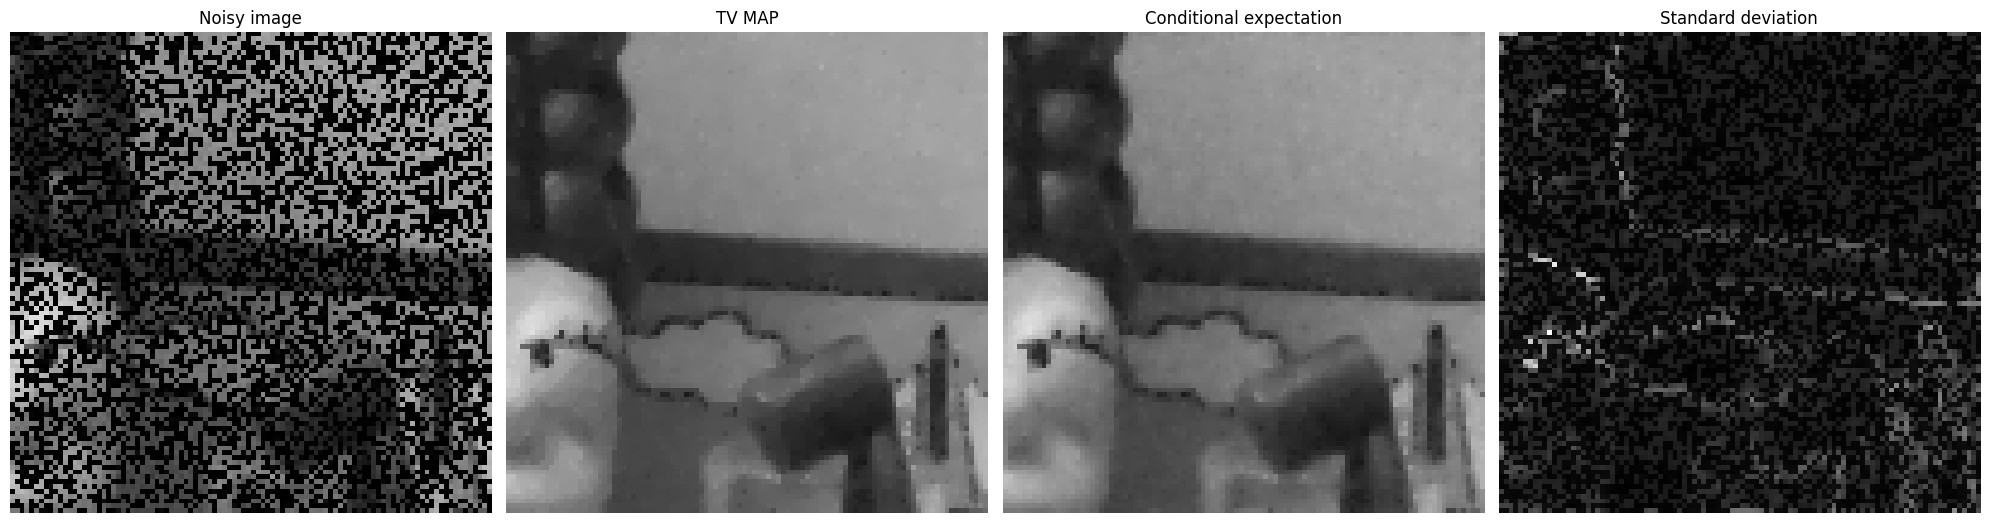

In [10]:
# Parameters for the MCMC
N = int(3e4)   # Choose N<1e4 for your experiments
alpha = 0.1  
lambd = 20
opts =  dict(ub=ub, sigma=sigma, lambd=lambd, mask=mask)

# Metropolis algorithm
t0   = time.time()
x = np.random.rand(nr,nc)
x,xmean,stdx = metropolis_TVL2A(x,alpha,N,**opts)
t1 = time.time()
print("time spent: ", t1-t0)

# TV-MAP
opt = dict(mask=mask)
u_tvmap = chambolle_pock_prox_TV("TVL2A",ub,sigma**2*lambd,200, **opt)

# Print results
print4Images(ub, u_tvmap, xmean, stdx, 'Noisy image', 'TV MAP', 'Conditional expectation', 'Standard deviation', 20, 5)